In [ ]:
from src import utils
imgs, labels = utils.load_imgs('../Wild Cats Dataset', ['CHEETAH' ,'OCELOT', 'SNOW LEOPARD', 'CARACAL', 'LIONS', 'PUMA', 'TIGER'])
x, y = utils.make_dataset(imgs, labels, utils.label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(x.shape, y.shape))
utils.plot_sample(imgs, labels, 5, 5, resize=(224, 224))

Iteration 0:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


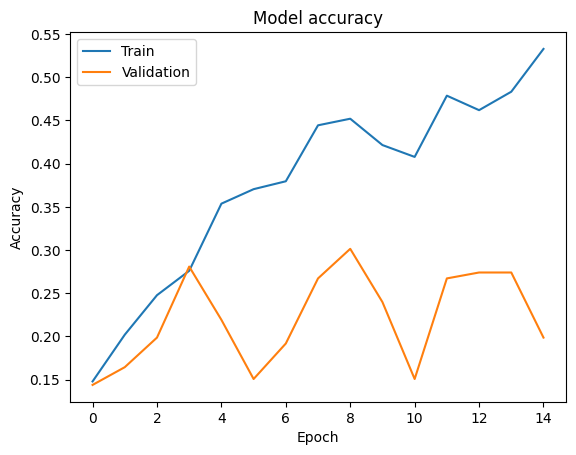

   Accuracy: 32.7161%

Iteration 1:


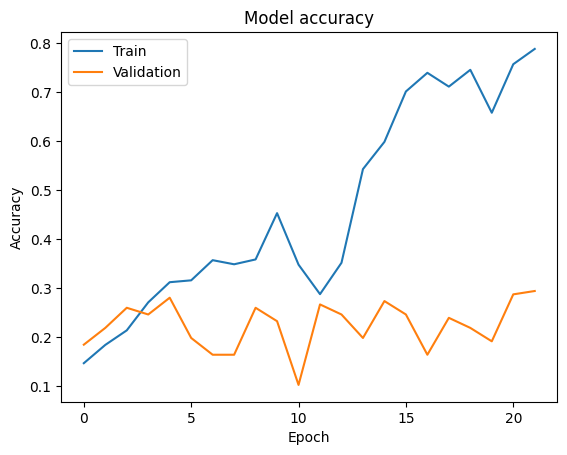

   Accuracy: 35.1852%

Iteration 2:


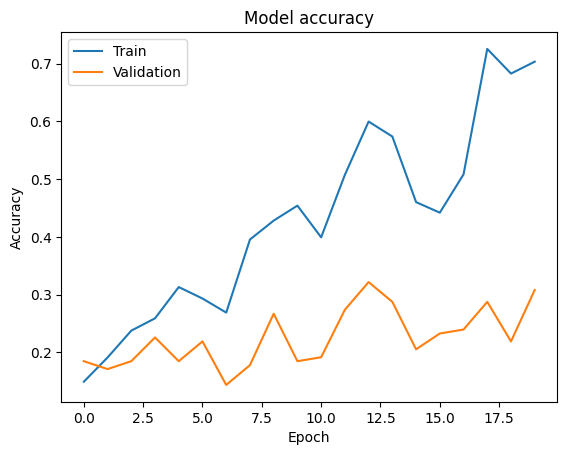

   Accuracy: 38.2716%

Iteration 3:


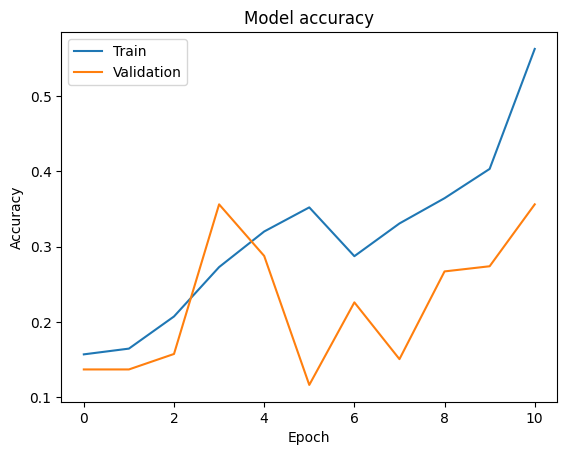

   Accuracy: 26.5432%

Iteration 4:


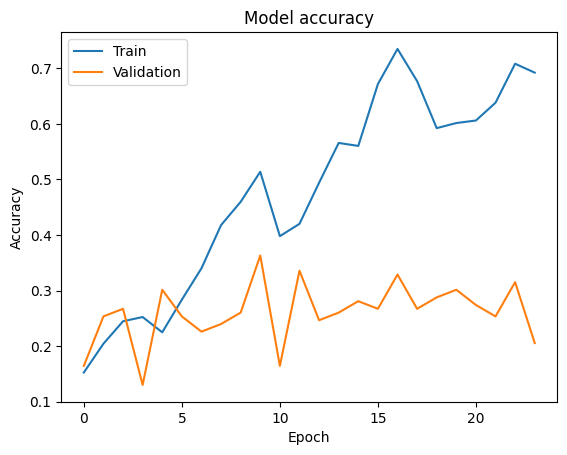

   Accuracy: 30.2469%

Mean accuracy: 0.3259 (+/- 0.0403)
Mean loss: 2.1180 (+/- 0.1519)


In [32]:
################### Task 1 ###################
# Solution go here
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten

# ------- 1, 2 -------
X = x / 255

keras.utils.set_random_seed(0)

# ------ 3, 4 -------
def create_model():
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


def plot_history(network):
    plt.plot(network.history.history['accuracy'])
    plt.plot(network.history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('T1_best_model.h5', monitor='val_accuracy', save_best_only=True)

# ------ 6 -------
# Initialize lists to store the evaluation metrics for each fold
accuracy_scores = []
loss_scores = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
split = sss.split(X, y)

for i, (train_index, test_index) in enumerate(split):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Iteration {i}:")

    network = create_model()
    # Train model on current fold's training data
    network.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping, model_checkpoint], verbose=0)

    plot_history(network)

    # Evaluate model on current fold's test data
    loss, accuracy = network.evaluate(x_test, y_test, verbose=0)
    print("   Accuracy: {:.4f}".format(accuracy * 100) + "%\n")

    accuracy_scores.append(accuracy)
    loss_scores.append(loss)

# Calculate the mean and standard deviation of the evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_loss = np.mean(loss_scores)
std_accuracy = np.std(accuracy_scores)
std_loss = np.std(loss_scores)

# Print the mean and standard deviation of the evaluation metrics
print("Mean accuracy: {:.4f} (+/- {:.4f})".format(mean_accuracy, std_accuracy))
print("Mean loss: {:.4f} (+/- {:.4f})".format(mean_loss, std_loss))



In [ ]:
################### Task 1 Bonus ###################
# Solution go here

In [ ]:
################### Task 2 ###################
# Solution go here
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

def plot_gen_sample(gen, n_cols=5, n_rows=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    batch = next(gen)[0]
    for ax, im in zip(axs.reshape(-1), batch):
        ax.axis('off')
        ax.imshow(im)

X = x / 255

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

print('x_train shape: {}, y_train shape:{}'.format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape:{}'.format(x_test.shape, y_test.shape))
print('x_train max: {}, x_train min:{}'.format(x_train.max(), x_train.min()))

train_gen = ImageDataGenerator(channel_shift_range=0.3,   # random channel shifts
                               rotation_range=30,         # rotation
                               zoom_range=0.3,            # zoom in/out randomly
                               shear_range=15)            # deformation

val_gen = ImageDataGenerator()

nr, nc = 5, 5

train_loader = train_gen.flow(x_train, y_train, batch_size=nr*nc)
val_loader = val_gen.flow(x_val, y_val, batch_size=x_val.shape[0])
# plot_gen_sample(train_loader, nr, nc)

def create_cnn():
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Classifier
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('T2_best_model.h5', monitor='val_accuracy', save_best_only=True)

batch_size = 32

conv_model = create_cnn()
# Fit the model
conv_model.fit(train_loader,
               steps_per_epoch=x_train.shape[0]//batch_size,
                epochs=100,
                validation_data=val_loader,
                validation_steps = 1,
                callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
test_loss, test_accuracy = conv_model.evaluate(x_test, y_test)

plot_history(conv_model)

# Print the test accuracy
print('Test Accuracy:', test_accuracy)

In [ ]:
################### Task 2 Bonus ###################
# Solution go here


